In [73]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm.notebook import trange, tqdm
from scipy.special import hermite, factorial
from numpy.typing import NDArray



from ipywidgets import interact, interactive
import ipywidgets as widgets
# import matplotlib.widgets as widgets
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
import matplotlib.animation as animation
from IPython.display import display
import seaborn as sns
rcparams = {
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (10, 6),
}
sns.set_theme(context="notebook", style="darkgrid", rc=rcparams, font_scale=1.2, palette="colorblind")




# from skimage.transform import iradon


In [74]:
for i in trange(3, desc="Outer loop", bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"):
    for j in trange(3, desc=f"Inner loop {i}", leave=False):
        # for k in trange(5, desc=f"Nested loop {i}.{j}", leave=False):
        # Simulate some work
        time.sleep(0.1)

Outer loop:   0%|           0/3 [00:00<?, ?it/s]

Inner loop 0:   0%|          | 0/3 [00:00<?, ?it/s]

Inner loop 1:   0%|          | 0/3 [00:00<?, ?it/s]

Inner loop 2:   0%|          | 0/3 [00:00<?, ?it/s]

In [75]:
# helpter functions to format strings
def format_complex(val):
    """    Format a complex number into a string representation.

    Args:
        val (complex): The complex number to format.

    Returns:
        outstr (str): A string representation of the complex number, formatted to two decimal places.
        If the real part is zero, it will only show the imaginary part. If both parts are zero, it returns "0". 
        The imaginary part is prefixed with '+' or '-' depending on its sign.
        The output is padded with spaces on both sides.
    """
    outstr = ""
    real_part = val.real
    imag_part = val.imag
    if real_part != 0:
        outstr += f"{real_part:.2f}"
    if imag_part != 0:
        if imag_part > 0:
            outstr += f"+{imag_part:.2f}j"
        else:
            outstr += f"-{abs(imag_part):.2f}j"
    return " " + outstr + " " if outstr else "0"

# Reconstruction

### TO DO:
- make reconstruction 
- compute fidelity
- compare different estimators (MLE, etc.)
- compare using different number of angles -- currently using 6 angles in $[0, \frac{5\pi}{6}]$
- compare using different binning for $X_\theta$

## Read data

In [76]:
data = np.load("measurements.npz")
thetas = data["thetas"]
measurements = data["samples"]

with np.printoptions(precision=3, linewidth=150, edgeitems=10, suppress=True):
    print(f"      thetas {thetas.shape}:", thetas)
    print(f"measurements {measurements.shape}:", measurements)

# display metadata using bash command
!cat measurements_metadata.txt


      thetas (12,): [0.    0.262 0.524 0.785 1.047 1.309 1.571 1.833 2.094 2.356 2.618 2.88 ]
measurements (12, 100000): [[ 3.077  2.809  2.007  2.274  3.13   3.023  2.756  3.398  2.916  3.773 ...  3.666  2.916  2.328  2.381  2.221  2.167  2.381  2.595  2.97   3.666]
 [ 3.612  3.933  3.452  1.418  2.809  3.505  2.595  4.361  3.237  2.542 ...  2.809  3.13   3.612  2.863  3.773  2.328  3.023  3.88   3.826  2.114]
 [ 4.254  2.488  3.452  3.184  3.077  4.468  3.666  3.184  3.344  3.719 ...  3.666  3.987  1.739  3.023  3.826  1.418  3.398  2.381  3.719  2.863]
 [ 2.809  1.846  4.254  3.666  3.023  3.505  2.595  3.291  3.559  3.773 ...  3.719  3.398  3.023  3.719  3.291  2.381  4.308  2.542  2.488  2.863]
 [ 2.702  1.686  2.435  3.077  2.542  3.077  3.666  1.204  1.686  2.542 ...  3.13   2.488  2.756  3.237  3.88   2.916  2.542  4.789  1.953  1.9  ]
 [ 2.916  2.328  1.311  2.488  2.007  1.151  1.204  2.06   2.488  2.007 ...  3.023  0.883  2.809  2.328  1.632  0.776  0.08   1.418  1.632  2.75

state_type,coherent
parity,even
alpha,(2+1j)
N_cutoff,30
thetas [radians],[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.308996938995747, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.617993877991494, 2.8797932657906435]


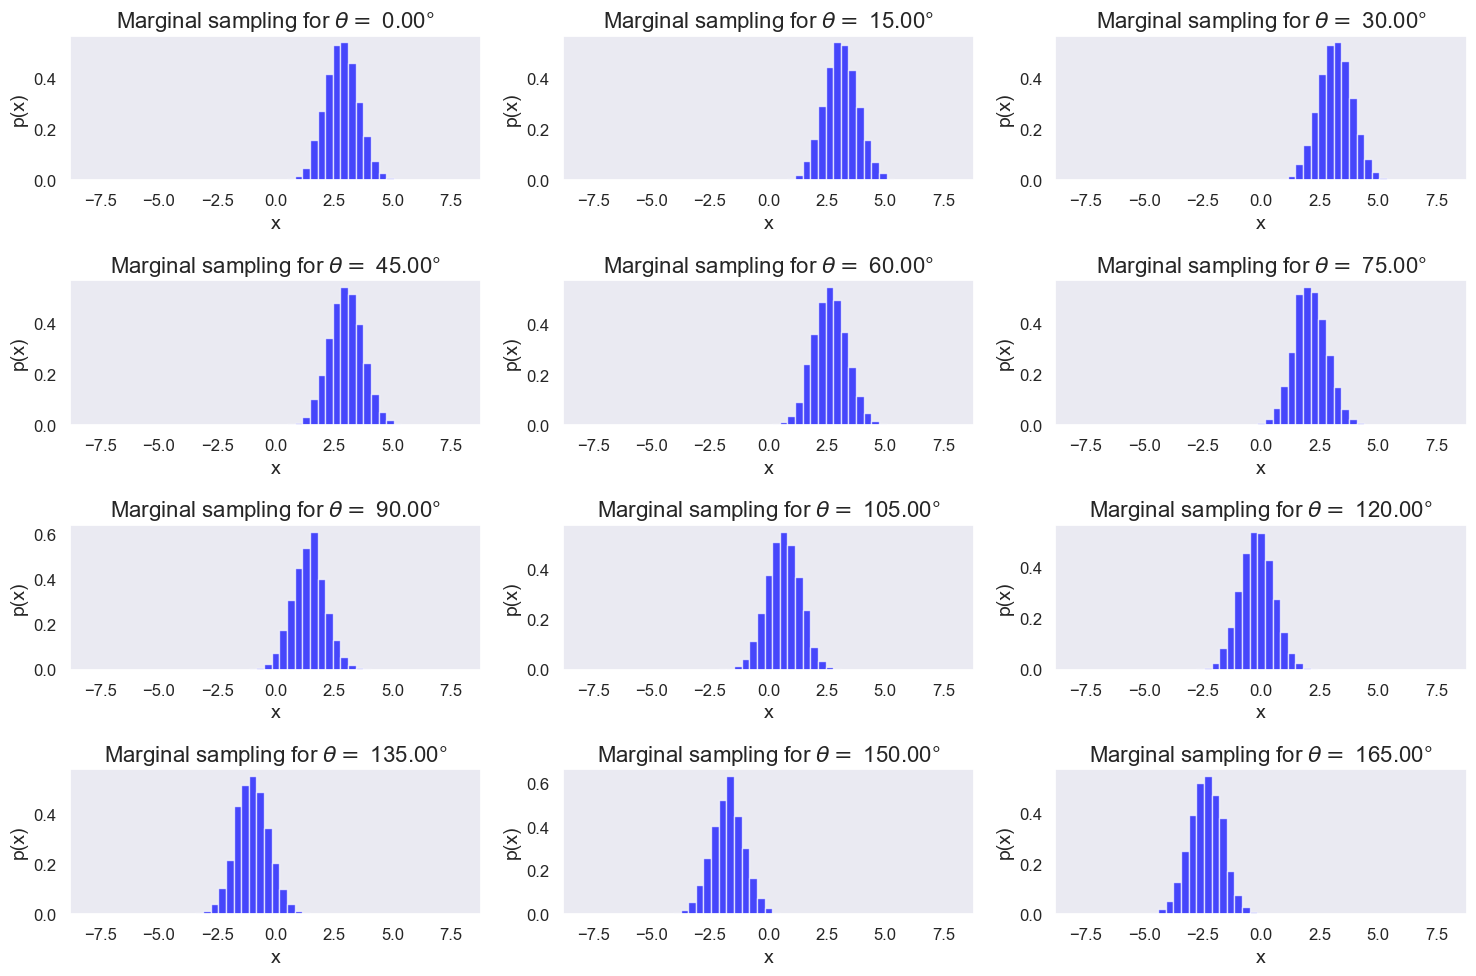

In [77]:
ncols = 3
nrows = len(thetas) // 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

axes = axes.flatten() if nrows > 1 else [axes]
for i, ax in enumerate(axes):
    ax.hist(x=measurements[i], bins=np.linspace(-8, 8, 50), density=True, alpha=0.7, color='blue')
    ax.set_title(f"Marginal sampling for $\\theta =$ {np.rad2deg(thetas[i]):.2f}°")
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")
    ax.grid()
    
fig.tight_layout()


## Load ground truth state

In [78]:
groundtruth = qt.fileio.qload("generated_state")
groundtruth

Quantum object: dims=[[30], [1]], shape=(30, 1), type='ket', dtype=Dense
Qobj data =
[[ 8.20849986e-02+1.11022302e-16j]
 [ 1.64169997e-01+8.20849986e-02j]
 [ 1.74128577e-01+2.32171437e-01j]
 [ 6.70221207e-02+3.68621664e-01j]
 [-1.17288711e-01+4.02132724e-01j]
 [-2.84745434e-01+3.07225337e-01j]
 [-3.57917892e-01+1.34601600e-01j]
 [-3.21435118e-01-3.35310015e-02j]
 [-2.15433952e-01-1.37354474e-01j]
 [-9.78378100e-02-1.63380967e-01j]
 [-1.02124660e-02-1.34270228e-01j]
 [ 3.43256484e-02-8.40471686e-02j]
 [ 4.40802500e-02-3.86156942e-02j]
 [ 3.51613899e-02-9.19447150e-03j]
 [ 2.12518794e-02+4.48262500e-03j]
 [ 9.81701451e-03+7.80202925e-03j]
 [ 2.95799994e-03+6.35526825e-03j]
 [-1.06538228e-04+3.80017828e-03j]
 [-9.45933213e-04+1.76630992e-03j]
 [-8.39243212e-04+5.93426611e-04j]
 [-5.08015196e-04+7.77279611e-05j]
 [-2.38677649e-04-7.69347438e-05j]
 [-8.53699247e-05-8.36913069e-05j]
 [-1.81509137e-05-5.27026575e-05j]
 [ 3.34775560e-06-2.52204344e-05j]
 [ 6.38384956e-06-9.41959713e-06j]
 [ 4.

## Background
The homodyne tomography experiment gives a set of data $(X_\theta, \theta)$  -- see [A. I. Lvovsky](../references/RevModPhys.81.299.pdf)

The data is generated in the [generateState notebook](generateState.ipynb) and save to the [data file](measurements.npz) and the [meta data file](measurements_metadata.txt)

### Radon transform

In [79]:
def inverse_radon(X, theta, xmax=10, pmax=10, res=101):
    
    x = np.linspace(-xmax, xmax, res)
    p = np.linspace(-pmax, pmax, res)
    X, P = np.meshgrid(x, p)

    N = len(X)
    norm = 1/(2*np.pi**2*N)
    
    pass

### Reconstruction using Maximum Likelihood Estimator 
Based on [A. I. Lvovsky - section III.B](../references/RevModPhys.81.299.pdf)

The probability of measuring $X_\theta$ from a density matrix $\hat{\rho}$ is $\mathrm{P}_\rho(X_\theta) = \mathrm{Tr}\left[\hat{\Pi}(X_\theta)\hat{\rho}\right]$ where $\hat{\rho}$ is density matrix and $X_\theta$ is the measurement.

The maximum likelihood estimator is the density matrix maximizing the (log)-likelihood:

$$
    \hat{\rho}_0 = \max_{\rho}{\left(\ln{\mathcal{L}}\right)}.
$$

We determine the optimal $\hat{\rho}_0$, the one maximizing the likelihood, iteratively as
$$
    \hat{\rho}^{(k+1)} =  \dfrac{\hat{R}\rho^{k}\hat{R}}{\mathrm{Tr}\left[\hat{R}\rho^{k}\hat{R}\right]}, 
$$
with rho being normalized to a unitary trace.

The operator $\hat{\Pi}(X_\theta) = \ket{X_\theta}\bra{X_\theta}$ is the project operator of our measurement state.

The iteration operator is defined as:
$$
    \hat{R} = \sum_i \dfrac{\hat{\Pi}(X_{\theta_i})}{P_\rho(X_{\theta_i})},
$$

and the log-likelihood for continous variables is defined as:

$$
    \ln\mathcal{L} = \sum_i \ln{P_\rho(X_\theta)}.
$$

but for discretized data we need to bin the data, and determine the frequency of the data being in some bin, and then we can determine the likelihood:

$$
    \mathcal{L}(\hat{\rho}) = \prod_j P_\rho(X_{\theta_j})^{f(X_{\theta_j})}
$$


Note: The notation $X_{\theta_j}$ is to be understood as the measurement of $\left(X_j, \theta_j\right)$ from the Homodyne Tomography experiment.



In [80]:
def update_density_matrix(rho : qt.Qobj, R: qt.Qobj) -> qt.Qobj:
    """Update the density matrix using the MLE formula."""
    updated_rho = R * rho * R
    updated_rho = updated_rho / updated_rho.tr()  # Normalize the updated density matrix
    return updated_rho

def SE_sol(x : NDArray, theta : NDArray, n : int) -> NDArray:
    
    Hn = lambda x: hermite(n)(x)
    fact = np.exp(1j*n*theta) * (2/np.pi)**0.25 / np.sqrt(2**n * factorial(n))
    return fact * Hn(x) * np.exp(-x**2 / 2)

def X_theta_bins(measurements: NDArray, num_bins: int) -> tuple[NDArray, NDArray]:
    """Create bins for the histogram for each angle theta.
    
    Args: 
        measurements (NDArray): The measurement data.
        num_bins (int): The number of bins.
    
    Returns:
        (X_bins, bin_centers) (NDArray, NDArray): A tuple containing the bin edges and bin centers.
    """
    xmin, xmax = measurements.min(), measurements.max() # set x_range from values of X_theta
    X_bins = np.linspace(xmin, xmax, num_bins + 1) 
    bin_centers = 0.5 * (X_bins[:-1] + X_bins[1:]) # Calculate bin centers from midpoint between edges
    return X_bins, bin_centers

def get_counts(bins: NDArray, measurements: NDArray, unique_theta: NDArray) -> NDArray:
    """Get the counts for each bin in the histogram.

    Args:
        bins (NDArray): The bin edges.
        measurements (NDArray): The measurement data.
        unique_theta (NDArray): The unique theta values.

    Returns:
        NDArray: The sinogram of counts. shape (len(unique_theta), len(bins) - 1)
    """
    num_theta = unique_theta.size
    M = len(bins) - 1
    print(f"Number of unique thetas: {num_theta}, Number of bins: {M}")
    sinogram = np.zeros(shape=(num_theta, M)) # Initialize sinogram of shape (num_theta, num_bins)
    # measurements = measurements.reshape((num_theta, -1))  # Reshape to (num_theta, -1)
    for i in range(num_theta):
        sinogram[i], _ = np.histogram(measurements[i, :], bins=bins, density=False)
    return sinogram


In [81]:

def dm_diagnostics(rho, N_expect=40, alpha_theory=2+2j):
    a = qt.destroy(rho.shape[0])
    tr_err = abs(rho.tr() - 1)
    herm_err = (rho - rho.dag()).norm()
    evals = np.linalg.eigvalsh(rho.full())
    purity = (rho*rho).tr().real
    a_mean = (rho * a).tr()
    n_mean = (rho * (a.dag()*a)).tr().real

    print(f"Trace error:   {tr_err:.2e}")
    print(f"Hermiticity ‖ρ-ρ†‖: {herm_err:.2e}")
    print(f"Min eigenvalue: {evals.min():.3e}, Max: {evals.max():.3f}")
    print(f"Purity Tr(ρ²):  {purity:.4f}")
    print(f"<a>:            {a_mean:.3f}  (theory {alpha_theory:.3f})")
    print(f"<n>:            {n_mean:.3f}  (theory {abs(alpha_theory)**2:.3f})")

    # Photon number distribution vs Poisson( nbar )
    nbar = abs(alpha_theory)**2
    N = rho.shape[0]
    p_n = np.array([(rho * qt.basis(N,n) * qt.basis(N,n).dag()).tr().real for n in range(N)])
    p_pois = np.array([np.exp(-nbar)*nbar**n/factorial(n) for n in range(N)])
    print("Top 10 p_n:", np.round(p_n[:10], 4))
    print("Top 10 Poisson:", np.round(p_pois[:10], 4))
    return dict(tr_err=tr_err, herm_err=herm_err, purity=purity, a_mean=a_mean, n_mean=n_mean, evals=evals)

def povm_completeness(E_bins):
    # E_bins is list of Qobj POVM elements for one theta
    S = sum(E_bins)
    err = (S - qt.qeye(S.shape[0])).norm()
    print("‖Σ_b E_b - I‖ =", err)

def compare_model_to_data(rho, E_bins, counts):
    # counts is 1D array for this theta; E_bins same length
    P = np.array([(rho*E).tr().real for E in E_bins])
    P /= P.sum()
    model = P
    data = counts / counts.sum()
    print("χ²:", np.sum((data-model)**2 / np.maximum(model,1e-12)))

In [82]:
def wavefunction_per_theta(bin_centers : NDArray, theta : float, N_cutoff=20, verbose=False) -> NDArray:
    """Calculate the wavefunction for a single angle theta.

    Args:
        bin_centers (NDArray): The bin centers for the quadrature measurements.
        theta (float): The angle for the quadrature measurements.
        N_cutoff (int): The cutoff for the number of Fock states to consider.
        verbose (bool, optional): Whether to print progress messages. Default is `False`.

    Returns:
        wf (qt.Qobj): The wavefunction  `<n|X,theta>`  for the given angle theta.
    """
    M = len(bin_centers)
    wf = np.zeros(shape=(M, N_cutoff), dtype=np.complex128)  # shape (M, N_cutoff)
    for n in range(N_cutoff):
        wf[:, n] = SE_sol(bin_centers, theta, n)
    return wf

def povm_elements(bin_centers, theta, N_cutoff, dx):
    """Return list of POVM elements E_j for bins centered at bin_centers."""
    wf = wavefunction_per_theta(bin_centers, theta, N_cutoff=N_cutoff)  # shape (M, N_cutoff)
    E_list = []
    for j in range(len(bin_centers)):
        # Construct |x,θ> in Fock basis
        ket = qt.Qobj(wf[j, :], dims=[[N_cutoff], [1]])  # column vector
        proj = ket * ket.dag()
        E_list.append(proj * dx)  # include Δx once
    return E_list



In [83]:
def MLE_reconstruct(measurements, thetas, N_cutoff=10, n_bins=50, max_iter=10, dilute=None, sanity=False, tolerance=1e-12):

    bin_edges, bin_centers = X_theta_bins(measurements=measurements, num_bins=n_bins)
    unique_theta = np.unique(thetas)
    M = unique_theta.size

    # Compute the sinogram
    sinogram = get_counts(bins=bin_edges, measurements=measurements, unique_theta=unique_theta)
    print(f"sinogram shape: {sinogram.shape}, unique_thetas: {unique_theta.shape}, bin_centers: {bin_centers.shape}")

    # precompute POVMs shape is  `(M, (N_cutoff, len(bin_centers)))`
    # povms = quadrature_povm(bin_centers=bin_centers, unique_thetas=unique_theta, N_cutoff=N_cutoff)

    wfs = {}
    for theta in unique_theta:
        wfs[theta] = wavefunction_per_theta(bin_centers, theta, N_cutoff=N_cutoff)
    print(f"wfs shape: {len(wfs), len(wfs[0]), wfs[0][0].shape}")
    
    if sanity:
        dx = np.abs(bin_edges[0] - bin_edges[1])  # width of the bins
        povms = {theta: povm_elements(bin_centers, theta, N_cutoff, dx) for theta in unique_theta}

    rho = qt.qeye(N_cutoff).unit() 
    log_likelihoods = []
    rho_hist = []
    rho_hist.append(rho)  # Store the initial density matrix
    # Iterate rho until convergence or max_iter reached
    for iter in tqdm(range(max_iter), desc="MLE Iterations"):
        # initialize R
        R = qt.Qobj(np.zeros((N_cutoff, N_cutoff), dtype=complex))
        ll = 0.0
        for i, theta in enumerate(unique_theta):
            psi_theta = wfs[theta] # <n|X, theta>
            if sanity:
                povm_completeness(povms[theta])  # Ensure psi_theta_list is 1
                compare_model_to_data(rho, povms[theta], sinogram[i, :])  # Compare model to data
            else:
                pass
            
            for k, C in enumerate(sinogram[i, :]): # count per bin for angle theta
                if C == 0: # if zero skip calculation
                    continue
                
                # Get the POVMs for the current theta
                psi = qt.Qobj(psi_theta[k])
                projection = psi.proj()  # Fock projection <n|X, theta><X,theta|m>
                prob = np.real((projection * rho).tr())
                R += C*projection/prob
                if prob < 0:
                    print(f"probability was negative for  theta, bin: {theta}, {k}  ")
                    prob = 1e-12
                    
                ll += C*np.log(prob)
        if not dilute is None:
            assert isinstance(dilute, (int, float)) and 0 < dilute <= 1, "Dilute must be a float between 0 and 1"
            rho = (1-dilute)*rho + dilute*update_density_matrix(rho, R)  # Update the density matrix using the MLE formula
        elif dilute is None:
            rho = update_density_matrix(rho, R) # Update the density matrix using the MLE formula
        else:
            raise ValueError("Dilute must be a float between 0 and 1 or None (the same as dilute=1)")
            
        
        # rho = rho / rho.tr()  # Normalize the updated density matrix
        rho_hist.append(rho)
        log_likelihoods.append(ll)
        if iter > 1:
            if np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tolerance:
                print(f"Convergence reached for {iter} iterations")
                break
    return rho, np.array(rho_hist), np.array(log_likelihoods), (bin_edges, bin_centers)

N_cutoff = 30
recon, rho_hist, log_likelihoods, (bin_edges, bin_centers) = MLE_reconstruct(measurements, thetas, N_cutoff=N_cutoff, dilute=None, sanity=False, n_bins=100, max_iter=800, tolerance=1e-6)


Number of unique thetas: 12, Number of bins: 100
sinogram shape: (12, 100), unique_thetas: (12,), bin_centers: (100,)
wfs shape: (12, 100, (30,))


MLE Iterations:   0%|          | 0/800 [00:00<?, ?it/s]

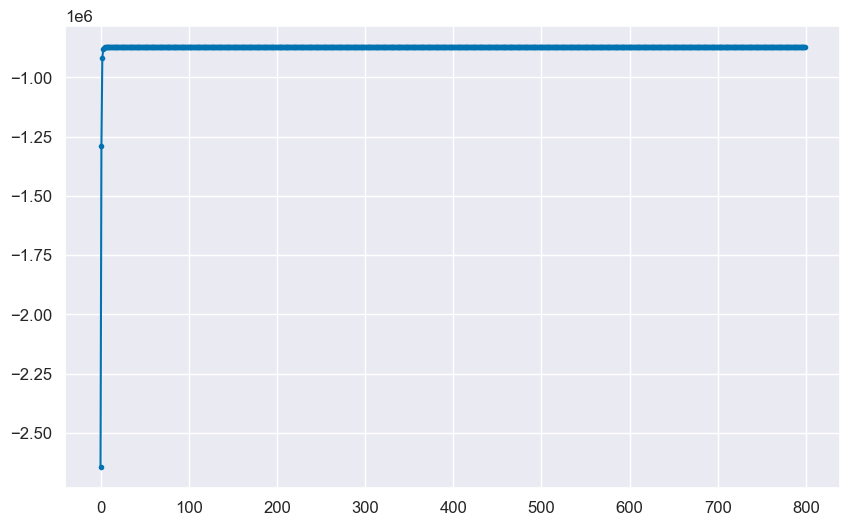

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_likelihoods[:], ".-",label="Log-likelihood")
None
# (log_likelihoods[990:] - log_likelihoods[:-990]).shape
# np.exp(log_likelihoods)

## Plot density matrix for reconstruction, ground truth, and their difference repectively

Text(0.5, 0.92, 'Difference')

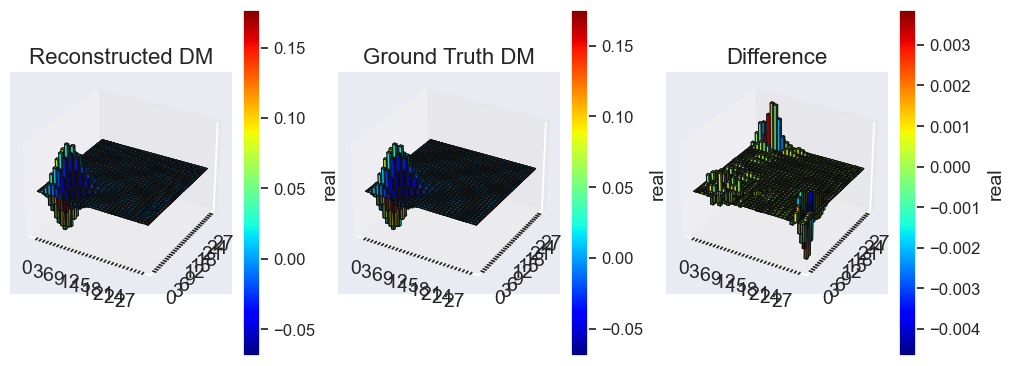

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': '3d'})
basis = [f"{i}" if i % 3 == 0 else " " for i in range(N_cutoff)]
bar_style = "img"
qt.matrix_histogram(recon, ax=ax1, fig=fig, x_basis=basis, y_basis=basis, bar_style=bar_style)
qt.matrix_histogram(qt.ket2dm(groundtruth), ax=ax2, fig=fig, x_basis=basis, y_basis=basis, bar_style=bar_style)
qt.matrix_histogram(qt.ket2dm(groundtruth) - recon, ax=ax3, fig=fig, x_basis=basis, y_basis=basis, bar_style=bar_style)

ax1.set_title("Reconstructed DM")
ax2.set_title("Ground Truth DM")
ax3.set_title("Difference")

# fig.tight_layout()

In [86]:
# Diagnostics of the reconstructed density matrix
with open("measurements_metadata.txt", "r") as f:
    lines = f.readlines()
    print("".join(lines))
dm_diagnostics(recon, N_expect=N_cutoff, alpha_theory=2+1j);

state_type,coherent
parity,even
alpha,(2+1j)
N_cutoff,30
thetas [radians],[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.308996938995747, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.617993877991494, 2.8797932657906435]

Trace error:   4.44e-16
Hermiticity ‖ρ-ρ†‖: 0.00e+00
Min eigenvalue: -1.450e-16, Max: 0.999
Purity Tr(ρ²):  0.9978
<a>:            2.000+0.999j  (theory 2.000+1.000j)
<n>:            5.014  (theory 5.000)
Top 10 p_n: [0.0067 0.0344 0.0833 0.1394 0.177  0.1729 0.1469 0.105  0.0657 0.036 ]
Top 10 Poisson: [0.0067 0.0337 0.0842 0.1404 0.1755 0.1755 0.1462 0.1044 0.0653 0.0363]


## Compute wigner function for $\rho$ history

In [87]:
print("computing wigner functions for rho hist")
x_vec = np.linspace(-8, 8, 100)
p_vec = x_vec.copy()
wigner_functions = []
for density in tqdm(rho_hist, desc="Computing Wigner functions"):
    # Compute the Wigner function for each density matrix in rho_hist
    wigner_functions.append(qt.wigner(density, x_vec, p_vec))

computing wigner functions for rho hist


Computing Wigner functions:   0%|          | 0/801 [00:00<?, ?it/s]

### Plot wigner functions and compare

In [88]:
x_vec = np.linspace(-8, 8, 100)
p_vec = x_vec.copy()

# fig, ax = plt.subplots(1,2, figsize=(12, 6))
cmap = "jet"
origin = "lower"

levels = 20

# Plot ground truth once


def update_wigner(iteration=0):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    gt_wigner = qt.wigner(qt.ket2dm(groundtruth), x_vec, p_vec)
    ax[1].contourf(x_vec, p_vec, gt_wigner, levels=levels, cmap=cmap, origin=origin)
    ax[1].set_title("Ground Truth Wigner Function")

    # Initial reconstruction plot
    recon_wigner = ax[0].contourf(x_vec, p_vec, wigner_functions[iteration], levels=levels, cmap=cmap, origin=origin)
    ax[0].set_title(f"Reconstruction Wigner Function (index {iteration})")
    fig.canvas.draw_idle()  # Update the figure canvas
    
# slider widget
iteration_slider = widgets.IntSlider(min=0, max=len(wigner_functions)-1, step=1, value=0, description="Iteration")
widgets.interact(update_wigner, iteration=iteration_slider)


interactive(children=(IntSlider(value=0, description='Iteration', max=800), Output()), _dom_classes=('widget-i…

<function __main__.update_wigner(iteration=0)>

Text(0.5, 0.98, 'Wigner Functions of Reconstructed and Ground Truth States')

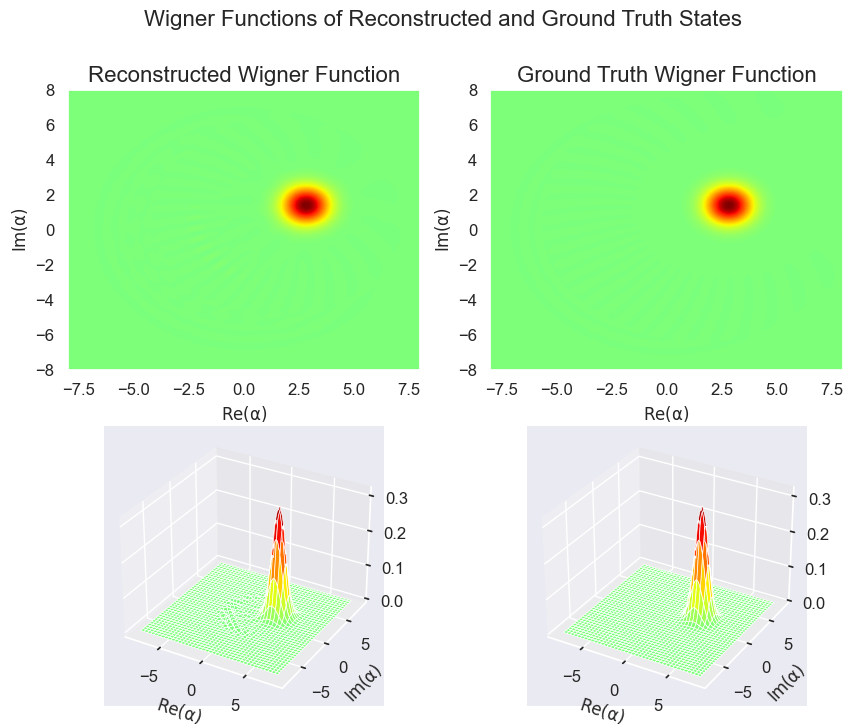

In [92]:
fig = plt.figure(figsize=(10, 8))

cmap = "jet"
xvec = np.linspace(-8, 8, 200)
yvec = np.linspace(-8, 8, 200)
method = "laguerre"

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection="3d")
ax4 = fig.add_subplot(224, projection="3d")
qt.plot_wigner(recon, fig=fig, ax=ax1, cmap=cmap, xvec=xvec, yvec=yvec, projection="2d", method=method)
qt.plot_wigner(groundtruth, fig=fig, ax=ax2, cmap=cmap, xvec=xvec, yvec=yvec, projection="2d", method=method)
qt.plot_wigner(recon, fig=fig, ax=ax3, cmap=cmap, xvec=xvec, yvec=yvec, projection="3d", method=method)
qt.plot_wigner(groundtruth, fig=fig, ax=ax4, cmap=cmap, xvec=xvec, yvec=yvec, projection="3d", method=method)


ax1.set_title("Reconstructed Wigner Function")
ax2.set_title("Ground Truth Wigner Function")

fig.suptitle("Wigner Functions of Reconstructed and Ground Truth States", fontsize=16)


Number of unique thetas: 12, Number of bins: 100


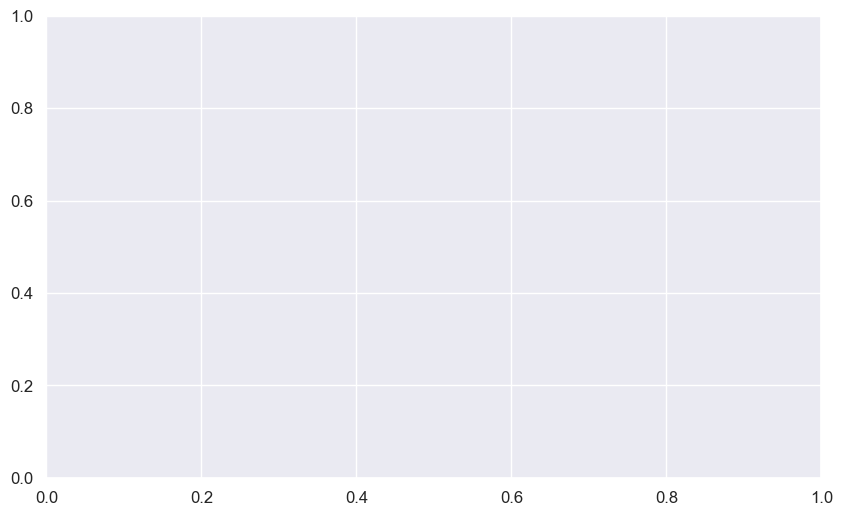

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
sinogram = get_counts(bins=bin_edges, measurements=measurements, unique_theta=thetas)

In [91]:
b, c = X_theta_bins(8, 2000)

unique_theta = np.unique(unique_thetas); 
# print("Unique thetas:", unique_theta)
X = measurements.reshape(len(unique_theta), -1)
sinogram = get_counts(b, X, unique_theta)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(c, sinogram.T / np.sum(sinogram, axis=1, keepdims=True).T, linestyle=':', markersize=3, label=[f'Counts for {theta:.3f}' for theta in unique_theta])
# ax[0].plot(np.linspace(-8, 8, X.shape[1]), X.T, alpha=0.5)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Counts')
ax[0].set_title('Histogram of Measurements')
ax[0].legend()

image = ax[1].imshow(sinogram, aspect='auto', extent=[b[0], b[-1], unique_theta[-1], unique_theta[0]], origin="lower", cmap="jet")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Theta')
ax[1].set_title('Sinogram')
fig.colorbar(image, ax=ax[1], label='Counts')

AttributeError: 'int' object has no attribute 'min'

In [ ]:
def quadrature_operator(N : int = 50, theta : float = 0.0) -> qt.Qobj:
    """Generate the quadrature operator for a given angle theta.

    Args:
        N (int): Dimension of the truncated Hilbert space.
        theta (float): Angle in radians for the quadrature operator.
    Returns:
        qt.Qobj: The quadrature operator corresponding to the angle theta.
    """
    a = qt.destroy(N)
    term = a * np.exp(-1j * theta)
    
    return (term + term.dag()) / np.sqrt(2)
        

def build_bins(N, thetas, n_bins=60, x_edges=None, tol=1e-12):
    """Build bins for the quadrature operator eigenstates based on the provided angles.

    Args:
        N (int): Dimension of the Hilbert space.
        thetas (ndarray): Array of angles in radians for which to compute the quadrature operators.
        n_bins (int, optional): Number of bins to create for the eigenvalues. Defaults to 60.
        x_edges (ndarray, optional): Edges for the bins. If `None`, they will be calculated based on the eigenvalues. 

    Returns:
        povms: List of POVMs (Positive Operator-Valued Measures) corresponding to the quadrature operators.
        x_edges: Edges of the bins.
        spectra: List of eigenvalues and eigenvectors for each quadrature operator. 
    """
    spectra = [quadrature_operator(N, theta).eigenstates() for theta in thetas]
    if x_edges is None: # If no edges are provided, calculate them based on the eigenvalues
        # Find the minimum and maximum eigenvalues across all spectra
        xmin = min(e.min() for e, _ in spectra)
        xmax = max(e.max() for e, _ in spectra) 
        pad = 1e-9 # Padding to avoid numerical issues
        x_edges = np.linspace(xmin - pad, xmax + pad, n_bins + 1) 
    
    povms = [] 
    for evals, evecs in tqdm(spectra, desc="Building bins", total=len(spectra)): 
        bin_indices = np.digitize(evals, x_edges) - 1  # -1 to convert to zero-based index
        E_bins = [qt.Qobj(np.zeros((N,N), dtype=np.complex128)) for _ in range(n_bins)] # Initialize bins with zero matrices
        # Fill the bins with the eigenvectors
        for i, bin in enumerate(bin_indices):
            if bin < 0: bin = 0 # Ensure bin index is within bounds
            if bin >= n_bins: bin = n_bins - 1 # Ensure bin index is within bounds
            E_bins[bin] += evecs[i] * evecs[i].dag() 
        povms.append(E_bins)
    return povms, x_edges, spectra

povms, edges, spectra = build_bins(N=50, thetas=unique_thetas, n_bins=60)
len(povms), len(povms[0]), len(edges), len(spectra), len(spectra[0][0]), len(spectra[0][1])

Building bins:   0%|          | 0/1212 [00:00<?, ?it/s]

(1212, 60, 61, 1212, 50, 50)

In [ ]:
def bin_samples(samples, thetas, x_edges, tol=1e-9):
    """This function takes samples and thetas, and bins them into quadrature bins defined by x_edges.

    Args:
        samples (ndarray): Array of samples to be binned.
        thetas (ndarray): Array of angles corresponding to the quadrature measurements.
        x_edges (ndarray): Edges of the bins for the quadrature measurements.
        tol (flaot, optional): tolerance. Defaults to 1e-9.
    Returns:
        counts (ndarray): 2D array where each row corresponds to a theta and each column corresponds to a bin defined by x_edges. The values are the counts of samples in each bin.
    Raises:
        ValueError: If any angle in `thetas` is not close to the corresponding angle in `thetas` within the specified tolerance.
    """
    
    thetas = np.asarray(thetas)
    n_thetas = len(thetas)
    n_bins = len(x_edges) - 1
    counts = np.zeros((n_thetas, n_bins), dtype=int)
    
    for X, th in zip(samples, thetas):
        # Find the bin index for each sample
        idx = np.argmin(np.abs(thetas - th))
        if np.abs(th - thetas[idx]) > tol:
            raise ValueError(f"Angle {th} not close to any theta in thetas. Found {thetas[idx]} instead.")
        
        # Digitize the samples into bins
        bin_indices = np.digitize(X, x_edges) - 1
        b = np.clip(bin_indices, 0, n_bins - 1)  # Ensure indices are within bounds
        counts[idx, b] += 1  # Increment the count for the corresponding bin
    return counts

sinogram = bin_samples(measurements, unique_thetas, edges)
sinogram.shape, (sinogram.sum(axis=1) > 0).sum(), (sinogram.sum(axis=0) > 0).sum()


((1212, 60), np.int64(6), np.int64(4))